In [1]:
# spark session
import os
import pyspark

conf = pyspark.SparkConf()
conf.set('spark.driver.memory','4g')
conf.set('spark.network.timeout', '600s')
conf.set('spark.executor.heartbeatInterval', '120s')

sc = pyspark.SparkContext(conf=conf)
sc.setLogLevel("ERROR")
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/12 20:18:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
file_path = "data/cleaned_data.csv"
df = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv(file_path)

In [3]:
df.printSchema()

root
 |-- NYPD_PCT_CD: integer (nullable = true)
 |-- BORO_NM: string (nullable = true)
 |-- RADIO_CODE: string (nullable = true)
 |-- CIP_JOBS: string (nullable = true)
 |-- INCIDENT_YEAR: integer (nullable = true)
 |-- INCIDENT_MONTH: integer (nullable = true)
 |-- TYP_DESC_HAS_TRANSIT: integer (nullable = true)
 |-- TYP_DESC_HAS_CRIME: integer (nullable = true)
 |-- TYP_DESC_HAS_KNIFE: integer (nullable = true)
 |-- TYP_DESC_HAS_CHASE: integer (nullable = true)
 |-- TYP_DESC_HAS_PROWLER: integer (nullable = true)
 |-- TYP_DESC_HAS_TRAIN: integer (nullable = true)
 |-- TYP_DESC_HAS_LARCENY: integer (nullable = true)
 |-- TYP_DESC_HAS_BURGLARY: integer (nullable = true)
 |-- TYP_DESC_HAS_HARASSMENT: integer (nullable = true)
 |-- TYP_DESC_HAS_TRAFFIC: integer (nullable = true)
 |-- TYP_DESC_HAS_ASSAULT: integer (nullable = true)
 |-- TYP_DESC_HAS_FIRE: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- WEEKDAY: integer (nullable = true)
 |-- TIME_TO_ARRIVE_FROM_DISPAT

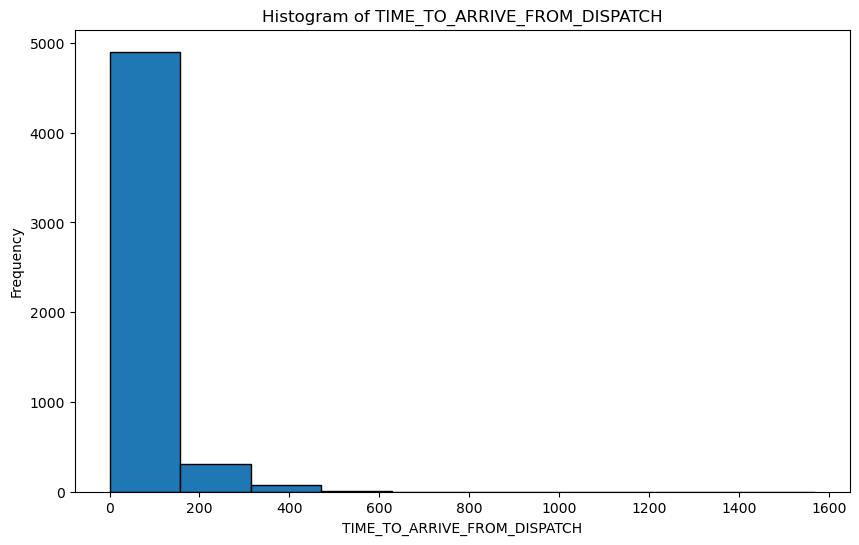

In [4]:
import numpy as np
import matplotlib.pyplot as plt


num_bins = 10

# Get the minimum and maximum values of the column
min_val = df.agg({"TIME_TO_ARRIVE_FROM_DISPATCH": "min"}).collect()[0][0]
max_val = df.agg({"TIME_TO_ARRIVE_FROM_DISPATCH": "max"}).collect()[0][0]

# Create bin edges
bin_edges = np.linspace(min_val, max_val, num_bins + 1)

# Calculate histogram
histogram = df.select("TIME_TO_ARRIVE_FROM_DISPATCH").rdd.flatMap(lambda x: x).histogram(list(bin_edges))

# Extract bin counts and bin edges
bin_counts = histogram[1]
bin_edges = histogram[0]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=bin_counts, edgecolor='black')
plt.xlabel('TIME_TO_ARRIVE_FROM_DISPATCH')
plt.ylabel('Frequency')
plt.title('Histogram of TIME_TO_ARRIVE_FROM_DISPATCH')
plt.show()

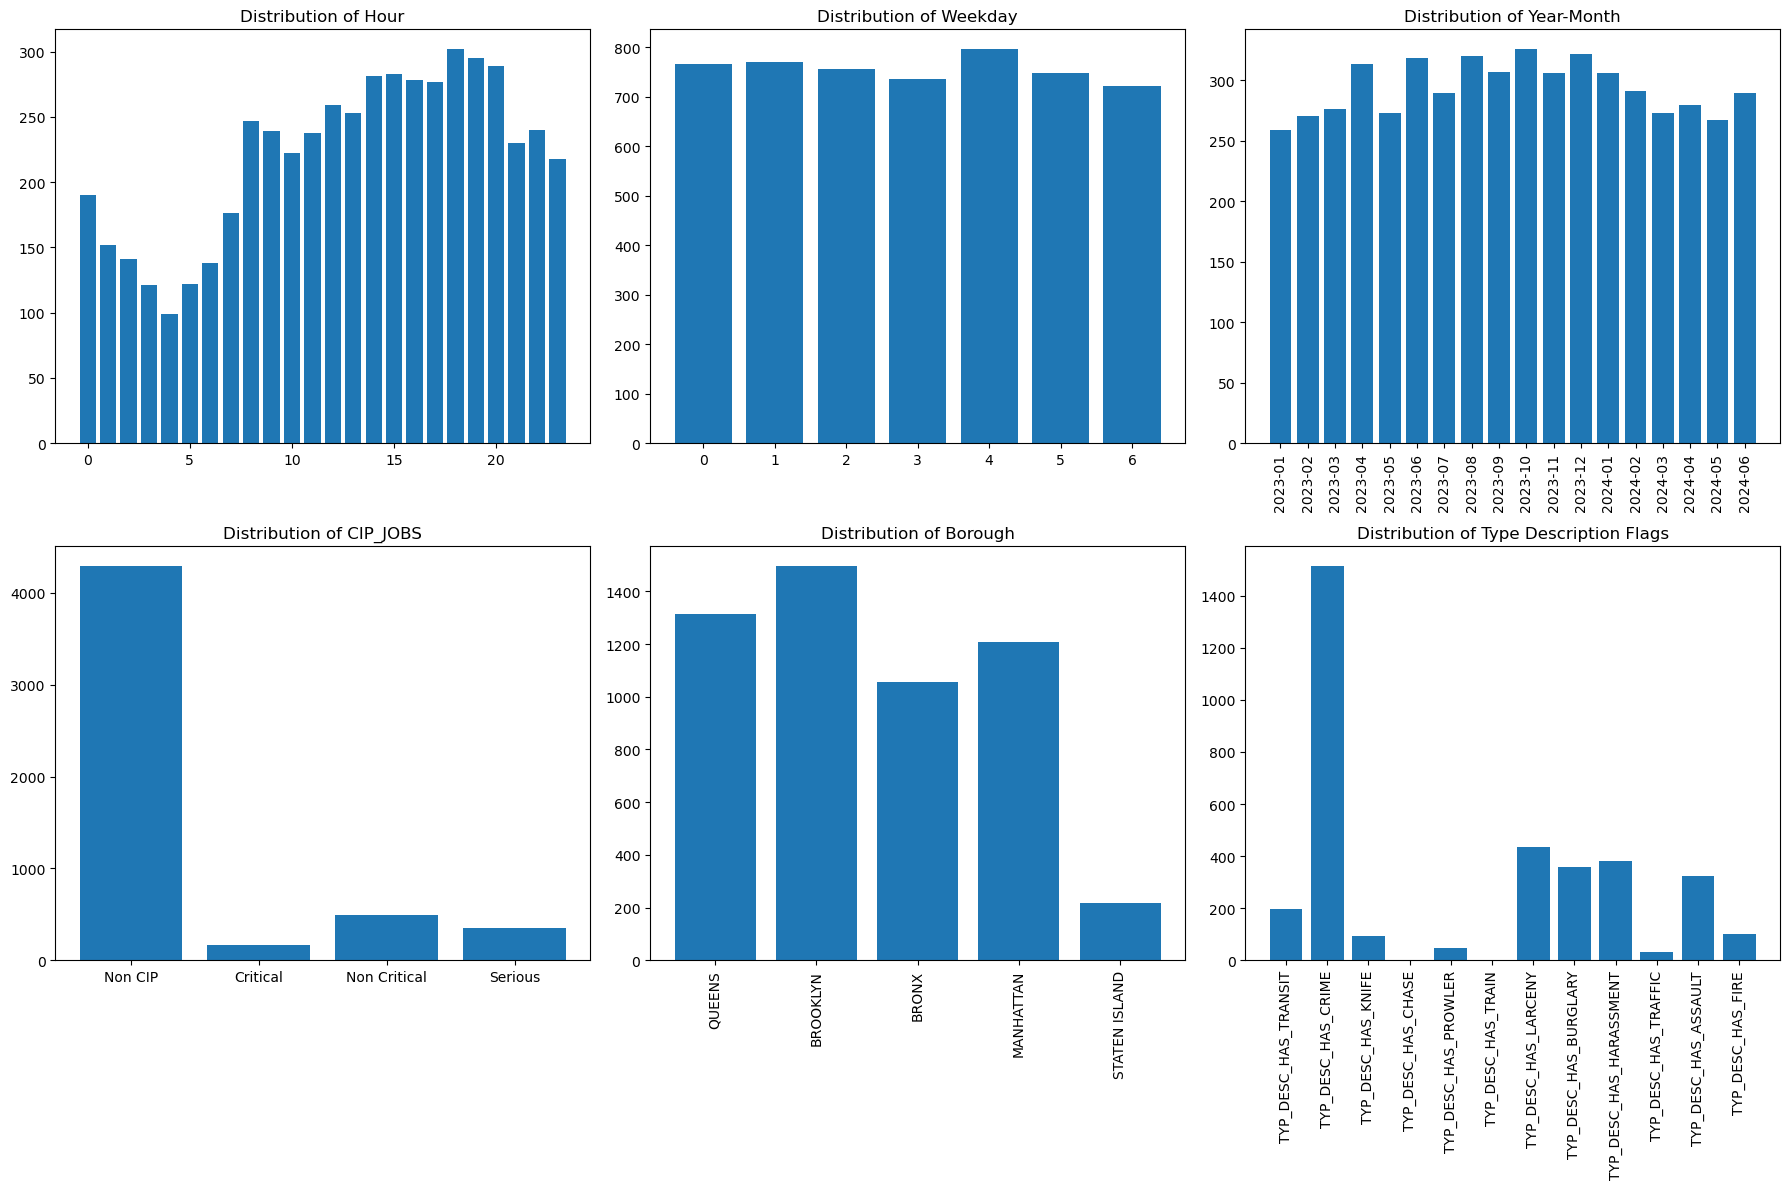

In [5]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as _sum
# Counts

HOUR = df.groupBy('HOUR').count().toPandas()
WEEKDAY = df.groupBy('WEEKDAY').count().toPandas()
YEAR_MONTH = df.groupBy('INCIDENT_YEAR', 'INCIDENT_MONTH').count().toPandas()\
    .sort_values(by=['INCIDENT_YEAR', 'INCIDENT_MONTH'])
CIP_JOBS = df.groupBy('CIP_JOBS').count().toPandas()
BORO_NM = df.groupBy('BORO_NM').count().toPandas()


typ_desc_columns = [col_name for col_name in df.columns if col_name.startswith('TYP_DESC_HAS')]
aggregations = [_sum(col(col_name)).alias(col_name) for col_name in typ_desc_columns]
sums_typ_desc = df.agg(*aggregations)
pandas_typ_desc = sums_typ_desc.toPandas()
TYP_DESC = pandas_typ_desc.T.reset_index()
TYP_DESC.columns = ['Column', 'Sum']

fig, axis = plt.subplots(2, 3, figsize=(18, 12))

# Plot the distributions
axis[0, 0].bar(HOUR['HOUR'], HOUR['count'])
axis[0, 0].set_title('Distribution of Hour')

axis[0, 1].bar(WEEKDAY['WEEKDAY'], WEEKDAY['count'])
axis[0, 1].set_title('Distribution of Weekday')

axis[0,2].bar(YEAR_MONTH.apply(lambda row: f"{int(row['INCIDENT_YEAR'])}-{int(row['INCIDENT_MONTH']):02d}", axis=1), YEAR_MONTH['count'])
axis[0, 2].set_title('Distribution of Year-Month')
axis[0, 2].tick_params(axis='x', rotation=90)

axis[1, 0].bar(CIP_JOBS['CIP_JOBS'], CIP_JOBS['count'])
axis[1, 0].set_title('Distribution of CIP_JOBS')

axis[1, 1].bar(BORO_NM['BORO_NM'], BORO_NM['count'])
axis[1, 1].set_title('Distribution of Borough')
axis[1, 1].tick_params(axis='x', rotation=90)

axis[1, 2].bar(TYP_DESC['Column'], TYP_DESC['Sum'])
axis[1, 2].set_title('Distribution of Type Description Flags')
axis[1, 2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

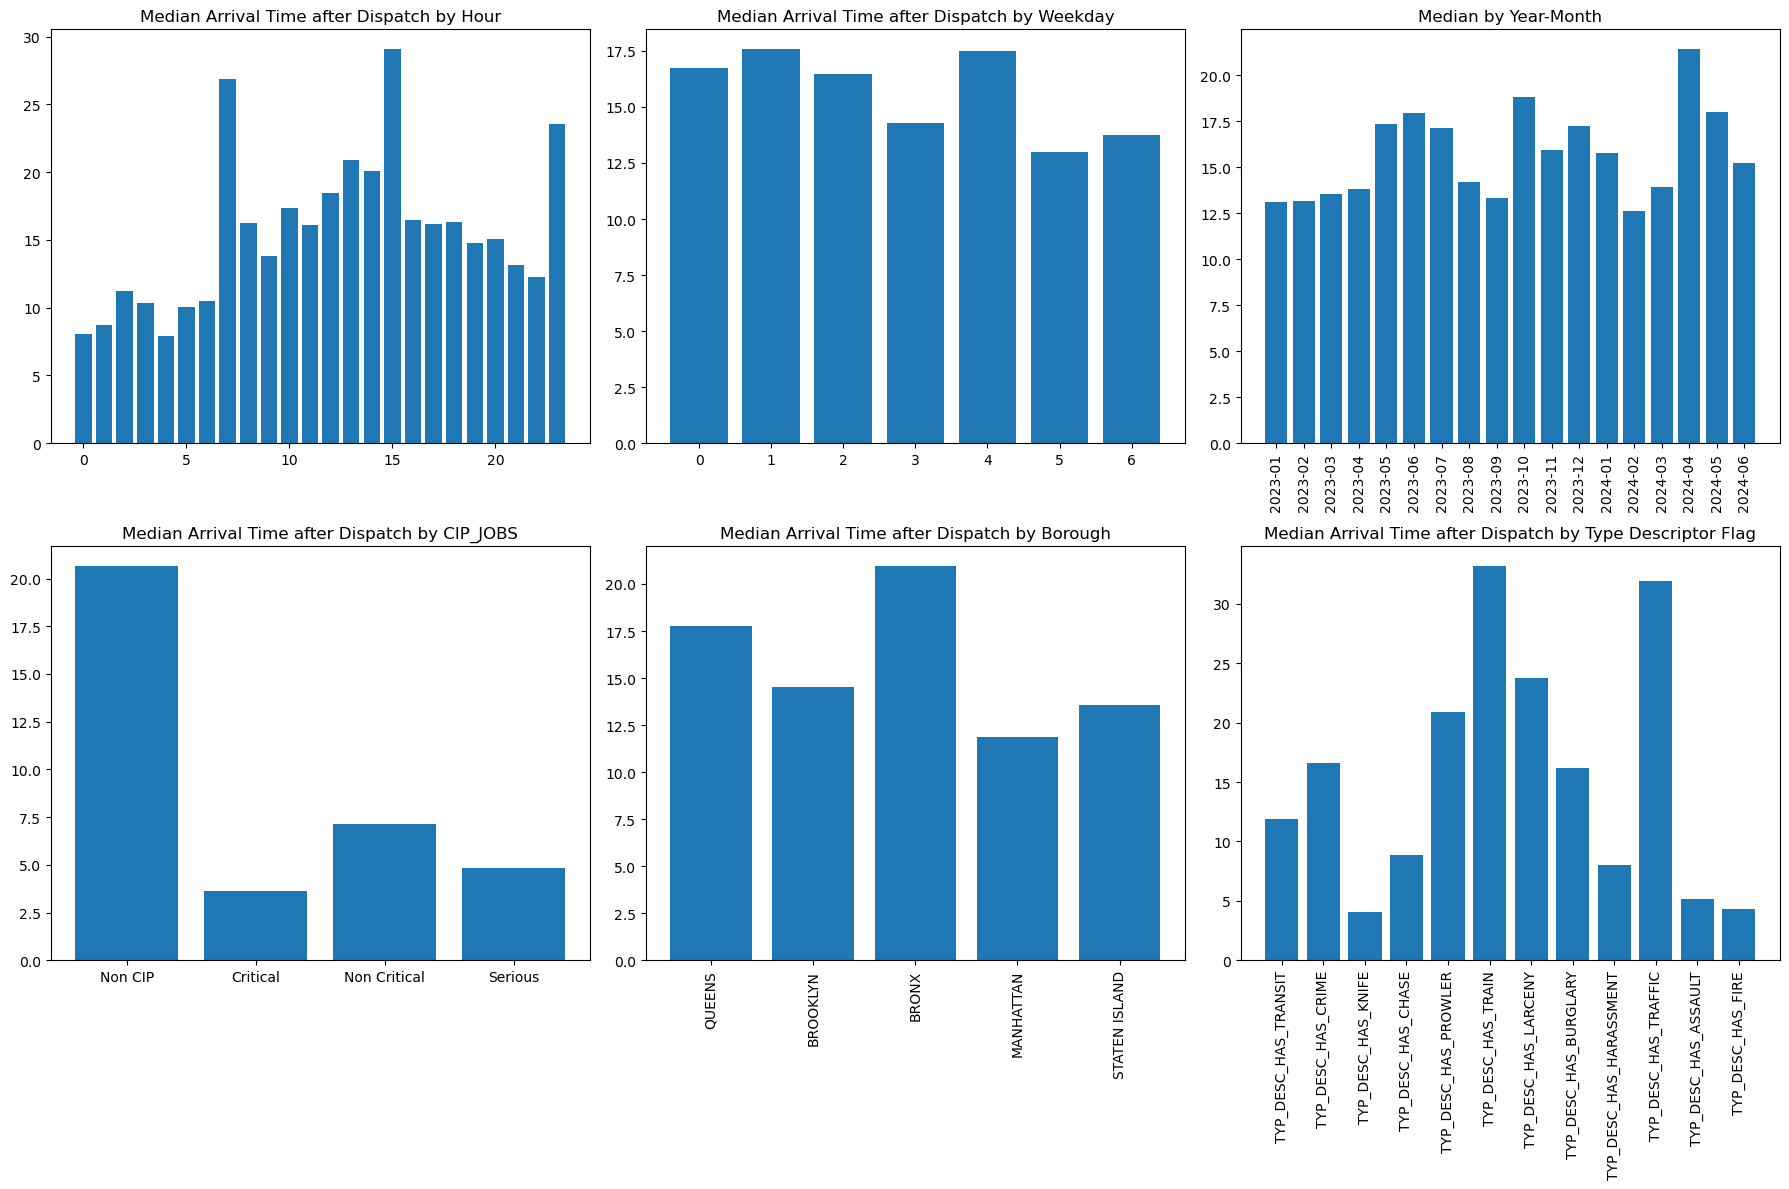

In [6]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to calculate median using approxQuantile
def calculate_median(df, group_col, agg_col):
    return df.groupBy(group_col).agg(
        F.expr(f'percentile_approx({agg_col}, 0.5)').alias('median')
    ).toPandas()

# Calculate medians
HOUR = calculate_median(df, 'HOUR', 'TIME_TO_ARRIVE_FROM_DISPATCH')
WEEKDAY = calculate_median(df, 'WEEKDAY', 'TIME_TO_ARRIVE_FROM_DISPATCH')
CIP_JOBS = calculate_median(df, 'CIP_JOBS', 'TIME_TO_ARRIVE_FROM_DISPATCH')
BORO_NM = calculate_median(df, 'BORO_NM', 'TIME_TO_ARRIVE_FROM_DISPATCH')
YEAR_MONTH = calculate_median(df, ['INCIDENT_YEAR', 'INCIDENT_MONTH'], 'TIME_TO_ARRIVE_FROM_DISPATCH')\
    .sort_values(by=['INCIDENT_YEAR', 'INCIDENT_MONTH'])

# Calculate medians for columns starting with 'TYP_DESC_HAS'
typ_desc_columns = [col_name for col_name in df.columns if col_name.startswith('TYP_DESC_HAS')]
medians_typ_desc = []

for col_name in typ_desc_columns:
    filtered_df = df.filter(F.col(col_name) == 1)
    median_value = filtered_df.agg(F.expr(f'percentile_approx(TIME_TO_ARRIVE_FROM_DISPATCH, 0.5)').alias(col_name)).collect()[0][col_name]
    medians_typ_desc.append((col_name, median_value))

TYP_DESC = pd.DataFrame(medians_typ_desc, columns=['Column', 'median'])

# Plot the distributions
fig, axis = plt.subplots(2, 3, figsize=(18, 12))

axis[0, 0].bar(HOUR['HOUR'], HOUR['median'])
axis[0, 0].set_title('Median Arrival Time after Dispatch by Hour')

axis[0, 1].bar(WEEKDAY['WEEKDAY'], WEEKDAY['median'])
axis[0, 1].set_title('Median Arrival Time after Dispatch by Weekday')

axis[0,2].bar(YEAR_MONTH.apply(lambda row: f"{int(row['INCIDENT_YEAR'])}-{int(row['INCIDENT_MONTH']):02d}", axis=1), YEAR_MONTH['median'])
axis[0, 2].set_title('Median by Year-Month')
axis[0, 2].tick_params(axis='x', rotation=90)

axis[1, 0].bar(CIP_JOBS['CIP_JOBS'], CIP_JOBS['median'])
axis[1, 0].set_title('Median Arrival Time after Dispatch by CIP_JOBS')

axis[1, 1].bar(BORO_NM['BORO_NM'], BORO_NM['median'])
axis[1, 1].set_title('Median Arrival Time after Dispatch by Borough')
axis[1, 1].tick_params(axis='x', rotation=90)

axis[1, 2].bar(TYP_DESC['Column'], TYP_DESC['median'])
axis[1, 2].set_title('Median Arrival Time after Dispatch by Type Descriptor Flag')
axis[1, 2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [7]:
# Group by BOROUGH and NEIGHBORHOOD and count occurrences
NEIGHBORHOOD = df.groupBy('BORO_NM', 'NEIGHBORHOOD').count().orderBy(col('count').desc()).toPandas()

In [8]:
median_df = calculate_median(df, ['BORO_NM', 'NEIGHBORHOOD'], 'TIME_TO_ARRIVE_FROM_DISPATCH')

In [9]:
import geopandas as gpd
#!pip install folium
import folium
from IPython.display import display, IFrame

nyc_neighborhoods = gpd.read_file('data/nyc_neighborhoods.geojson')
nyc_neighborhoods = nyc_neighborhoods.rename(columns={'neighborhood': 'NEIGHBORHOOD'})
merged = nyc_neighborhoods.merge(NEIGHBORHOOD, on='NEIGHBORHOOD')

min_value = merged['count'].min()
max_value = merged['count'].max()
bins = pd.cut(merged['count'], bins=5, labels=['very low', 'low', 'medium', 'high', 'very high'])

# Assign colors to each bucket
color_map = {
    'very low': 'green',
    'low': 'yellowgreen',
    'medium': 'yellow',
    'high': 'orange',
    'very high': 'red'
}
merged['color'] = bins.map(color_map)

# Create a folium map centered around NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add neighborhoods to the map with colors based on the bucket
for _, row in merged.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=row['color']: {'fillColor': color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=f"{row['NEIGHBORHOOD']}: {row['count']}"
    ).add_to(m)

# Save map to an HTML file
m.save('nyc_neighborhoods_map.html')

# Display the map in a Jupyter Notebook
from IPython.display import display, IFrame
display(IFrame('nyc_neighborhoods_map.html', width=800, height=600))

In [10]:
merged = nyc_neighborhoods.merge(median_df, on='NEIGHBORHOOD')

min_value = merged['median'].min()
max_value = merged['median'].max()
bins = pd.cut(merged['median'], bins=5, labels=['very low', 'low', 'medium', 'high', 'very high'])

# Assign colors to each bucket
color_map = {
    'very low': 'green',
    'low': 'yellowgreen',
    'medium': 'yellow',
    'high': 'orange',
    'very high': 'red'
}
merged['color'] = bins.map(color_map)

# Create a folium map centered around NYC
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add neighborhoods to the map with colors based on the bucket
for _, row in merged.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=row['color']: {'fillColor': color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6},
        tooltip=f"{row['NEIGHBORHOOD']}: {row['median']}"
    ).add_to(m)

# Save map to an HTML file
m.save('nyc_neighborhoods_map.html')

# Display the map in a Jupyter Notebook
from IPython.display import display, IFrame
display(IFrame('nyc_neighborhoods_map.html', width=800, height=600))